In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np

1. Dataset Selection & EDA

In [2]:
# Load IMDB dataset from Hugging Face
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]

print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

Using the latest cached version of the dataset since imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\hp\.cache\huggingface\datasets\imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Tue Apr  8 12:05:30 2025).


Training samples: 25000
Test samples: 25000


In [3]:
# Basic EDA
# Class distribution
labels = [example["label"] for example in train_data]
print(f"\nClass distribution: {np.bincount(labels)}")


Class distribution: [12500 12500]


In [4]:
# Text length analysis
text_lengths = [len(example["text"].split()) for example in train_data]
print(f"Average text length: {np.mean(text_lengths):.2f} words")
print(f"Max text length: {np.max(text_lengths)} words")

Average text length: 233.79 words
Max text length: 2470 words


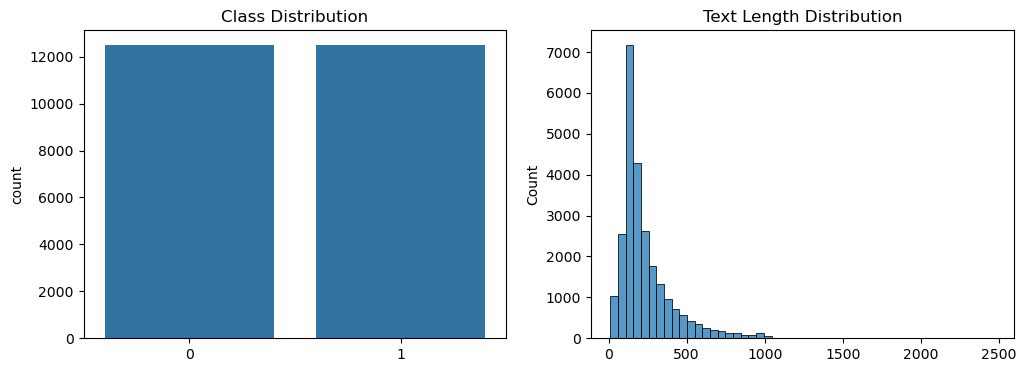

In [5]:
# Visualization
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(x=labels)
plt.title("Class Distribution")

plt.subplot(1, 2, 2)
sns.histplot(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.show()

2. Model Implementation

In [6]:
# Preprocessing
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts([example["text"] for example in train_data])

In [7]:
# Convert text to sequences
X_train = tokenizer.texts_to_sequences([example["text"] for example in train_data])
X_test = tokenizer.texts_to_sequences([example["text"] for example in test_data])

In [8]:
# Pad sequences
max_length = 200  # Based on EDA
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

y_train = np.array([example["label"] for example in train_data])
y_test = np.array([example["label"] for example in test_data])

In [9]:
# Split validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [10]:
# Model architecture
model = Sequential()
model.add(Embedding(10000, 128, input_length=max_length))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

C:\Users\hp\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [11]:
# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 366ms/step - accuracy: 0.6947 - loss: 0.5469 - val_accuracy: 0.8428 - val_loss: 0.3704
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 96s 614ms/step - accuracy: 0.9079 - loss: 0.2426 - val_accuracy: 0.8636 - val_loss: 0.3425
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 86s 548ms/step - accuracy: 0.9406 - loss: 0.1641 - val_accuracy: 0.8626 - val_loss: 0.3519
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 494ms/step - accuracy: 0.9610 - loss: 0.1114 - val_accuracy: 0.8692 - val_loss: 0.3726
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 492ms/step - accuracy: 0.9778 - loss: 0.0748 - val_accuracy: 0.8410 - val_loss: 0.4238


3. Evaluation

782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step

Test Accuracy: 0.8503
F1 Score: 0.8507


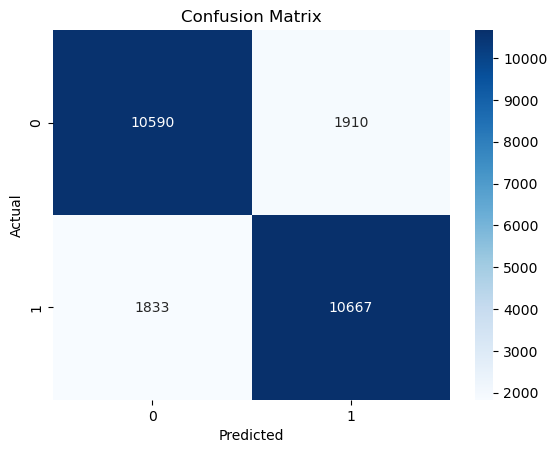

In [12]:
# Predictions
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Metrics
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

4. Deployment

In [13]:
def predict_sentiment(text):
    # Preprocess input
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length)
    
    # Predict
    prediction = model.predict(padded, verbose=0)[0][0]
    sentiment = "Positive" if prediction > 0.5 else "Negative"
    confidence = prediction if sentiment == "Positive" else 1 - prediction
    
    return f"{sentiment} sentiment ({confidence:.2f} confidence)"

In [ ]:
# CLI Interface
print("\nSentiment Analysis CLI (type 'exit' to quit)")
while True:
    text = input("\nEnter text: ")
    if text.lower() == "exit":
        break
    if len(text.strip()) == 0:
        print("Error: Please enter valid text")
        continue
    
    print(predict_sentiment(text))


Sentiment Analysis CLI (type 'exit' to quit)
Error: Please enter valid text
Positive sentiment (0.75 confidence)
Negative sentiment (0.51 confidence)
Positive sentiment (0.82 confidence)
Positive sentiment (0.79 confidence)
Positive sentiment (0.79 confidence)
Positive sentiment (0.63 confidence)
Positive sentiment (0.57 confidence)
Negative sentiment (0.81 confidence)
Positive sentiment (0.79 confidence)
Positive sentiment (0.75 confidence)
Positive sentiment (0.71 confidence)
Positive sentiment (0.61 confidence)
Positive sentiment (0.65 confidence)
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: Please enter valid text
Error: P

In [ ]:


# ---------------------------
# 1. Dataset Selection & EDA
# ---------------------------





# ---------------------------
# 2. Model Implementation
# ---------------------------



# ---------------------------
# 3. Evaluation
# ---------------------------



# ---------------------------
# 4. Deployment
# ---------------------------



